In [1]:
import numpy as np
from cmeutils.sampling import is_equilibrated, equil_sample
from cmeutils.structure import (
    gsd_rdf,
    structure_factor,
#    diffraction_pattern,
#    get_quaternions,
#    #nematic_order_parameter
)
#from cmeutils.polymers import get_bond_vectors

import unyt as u
from unyt import Unit
import signac
import gsd.hoomd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import freud
import rowan

import os
import grits
import mbuild as mb
import ele
import matplotlib

conv_dict = {
    "ca": ele.element_from_symbol("C"),
    "s": ele.element_from_symbol("S"),
    "sh": ele.element_from_symbol("S"),
}

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************

/home/chrisjones4/miniconda3/envs/pps-msibi/lib/python3.11/site-packages/mdtraj/formats/__init__.py:6: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  from 

In [2]:
# Matplotlib RC Params:    
color_dict = {1.0: "#0F0E0F", 0.8: "#666666", 0.7: "#964d4d", 0.6: "#d03f3f"}
symbol_dict = {1.0: "o", 0.8: "s", 0.7: "^", 0.6: "d"}
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams["axes.labelsize"] = 10
plt.rcParams["legend.fontsize"] = 7
plt.rcParams['lines.markersize'] = 1
plt.rcParams["lines.linestyle"] = "-"
plt.rcParams["lines.linewidth"] = 1
plt.rcParams["figure.dpi"] = 1200
plt.rcParams["legend.markerscale"] = 3

colors = [
    "#FF5733",  # Vermilion
    "#FFC300",  # Saffron
    "#4B0082",  # Indigo
    "#00A86B",  # Jade
    "#007FFF",  # Azure
    "#D2691E",  # Chocolate
    "#FF4500",  # Orange Red
    "#6A0DAD",  # Purple
    "#2E8B57",  # Sea Green
    "#FF6EC7",  # Blush Pink
    "#800080",  # Purple
    "#4682B4",  # Steel Blue
    "#008B8B",  # Dark Cyan
    "#E9967A",  # Dark Salmon
    "#FFD700",  # Gold
    "#800000",  # Maroon 
]

def get_bond_vectors(snapshot, bond_type_filter=None):
    """Get all normalized bond vectors of a certain bond type.

    Parameters
    ---------
    snapshot : gsd.hoomd.Frame, required
        Frame of the GSD trajectory file to use
    bond_types : list-like, required
        List of bond types to find bond vectors
        Choose from options found in gsd.hoomd.Frame.bonds.types

    Returns
    ------
    vectors : List of arrays (shape=(1,3)
        List of all normalized bond vectors matching bond_types

    """
    if not bond_type_filter:
        bond_type_filter = snapshot.bonds.types
    vectors = []
    for bond in bond_type_filter:
        if bond not in snapshot.bonds.types:
            raise ValueError(
                f"Bond type {bond} not found in snapshot.bonds.types"
            )
        bond_id = snapshot.bonds.types.index(bond)
        bond_indices = np.where(snapshot.bonds.typeid == bond_id)[0]
        for i in bond_indices:
            bond_group = snapshot.bonds.group[i]
            p1 = snapshot.particles.position[bond_group[0]]
            p2 = snapshot.particles.position[bond_group[1]]
            vectors.append((p2 - p1) / np.linalg.norm(p2 - p1))
    return vectors

def generate_color_gradient(start_color, end_color, num_steps):
    """Generate a gradient of colors between two given colors.

    Parameters:
    - start_color: Starting color in RGB format (e.g., [r, g, b])
    - end_color: Ending color in RGB format (e.g., [r, g, b])
    - num_steps: Number of steps in the gradient

    Returns:
    - colors: List of color codes representing the gradient
    """
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", [start_color, end_color])
    norm = mcolors.Normalize(vmin=0, vmax=num_steps-1)
    colors = [cmap(norm(i)) for i in range(num_steps)]
    return colors


def nematic_order_parameter(vectors, director):
    """Finds the nematic (S2) order parameter for a list of vectors
    Parameters
    ----------
    vectors : sequence of vectors; required
        The list of vectors to use in the nematic order parameter calculation
    director : numpy.ndarray, shape=(1,3)
        The nematic director of the reference state

    Returns
    -------
    freud.order.Nematic
    """
    vectors = np.asarray(vectors)
    orientations = rowan.normalize(
        np.append(np.zeros((vectors.shape[0], 1)), vectors, axis=1)
    )
    nematic = freud.order.Nematic(np.asarray(director))
    nematic.compute(orientations)
    return nematic
    

def kT_to_T(kT, epsilon):
    """kT converted to C"""
    return ((kT*epsilon)/8.31446262) - 273.15

In [3]:
project = signac.get_project("../training-runs/low-density-states/")

# Coarse-grain the trajectories

In [4]:
bead_mapping = {"A": "c1ccc(S)cc1"}
for job in project:
    cg_system = grits.coarsegrain.CG_System(
        gsdfile=job.fn("trajectory.gsd"),
        beads=bead_mapping,
        add_hydrogens=job.sp.remove_hydrogens,
        length_scale=job.doc.ref_length,
        mass_scale=job.doc.ref_mass,
        conversion_dict=conv_dict
    )
    cg_system.save(job.fn("target-1monomer-per-bead.gsd"))

Added 102 hydrogens.


/home/erjank_project/PPS-MSIBI/chris-scratch-space/repos/grits/grits/coarsegrain.py:193: UserWarning: Some atoms have been left out of coarse-graining!
  warn(f"Some atoms have been left out of coarse-graining!")
/home/chrisjones4/miniconda3/envs/pps-msibi/lib/python3.11/site-packages/gsd/hoomd.py:835: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if matches_default_value and not self._chunk_exists_frame_0.get(


Added 102 hydrogens.


/home/chrisjones4/miniconda3/envs/pps-msibi/lib/python3.11/site-packages/gsd/hoomd.py:835: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if matches_default_value and not self._chunk_exists_frame_0.get(


Added 102 hydrogens.


/home/chrisjones4/miniconda3/envs/pps-msibi/lib/python3.11/site-packages/gsd/hoomd.py:835: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if matches_default_value and not self._chunk_exists_frame_0.get(


Added 102 hydrogens.


/home/chrisjones4/miniconda3/envs/pps-msibi/lib/python3.11/site-packages/gsd/hoomd.py:835: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if matches_default_value and not self._chunk_exists_frame_0.get(


# RDFs:

In [7]:
job.project.path

'/home/erjank_project/PPS-MSIBI/pps-msibi/training-runs/low-density-states'

2d4c1f719fd4e9e583a9d1ff64e26d69 1.0 10
b502508875f8bc405beb87b58ea2ba9c 3.0 10
f68738b5c870ddf535be138a7cda4adf 1.0 50
5f74799263ad8fdad51aa658a4ad2f38 3.0 50


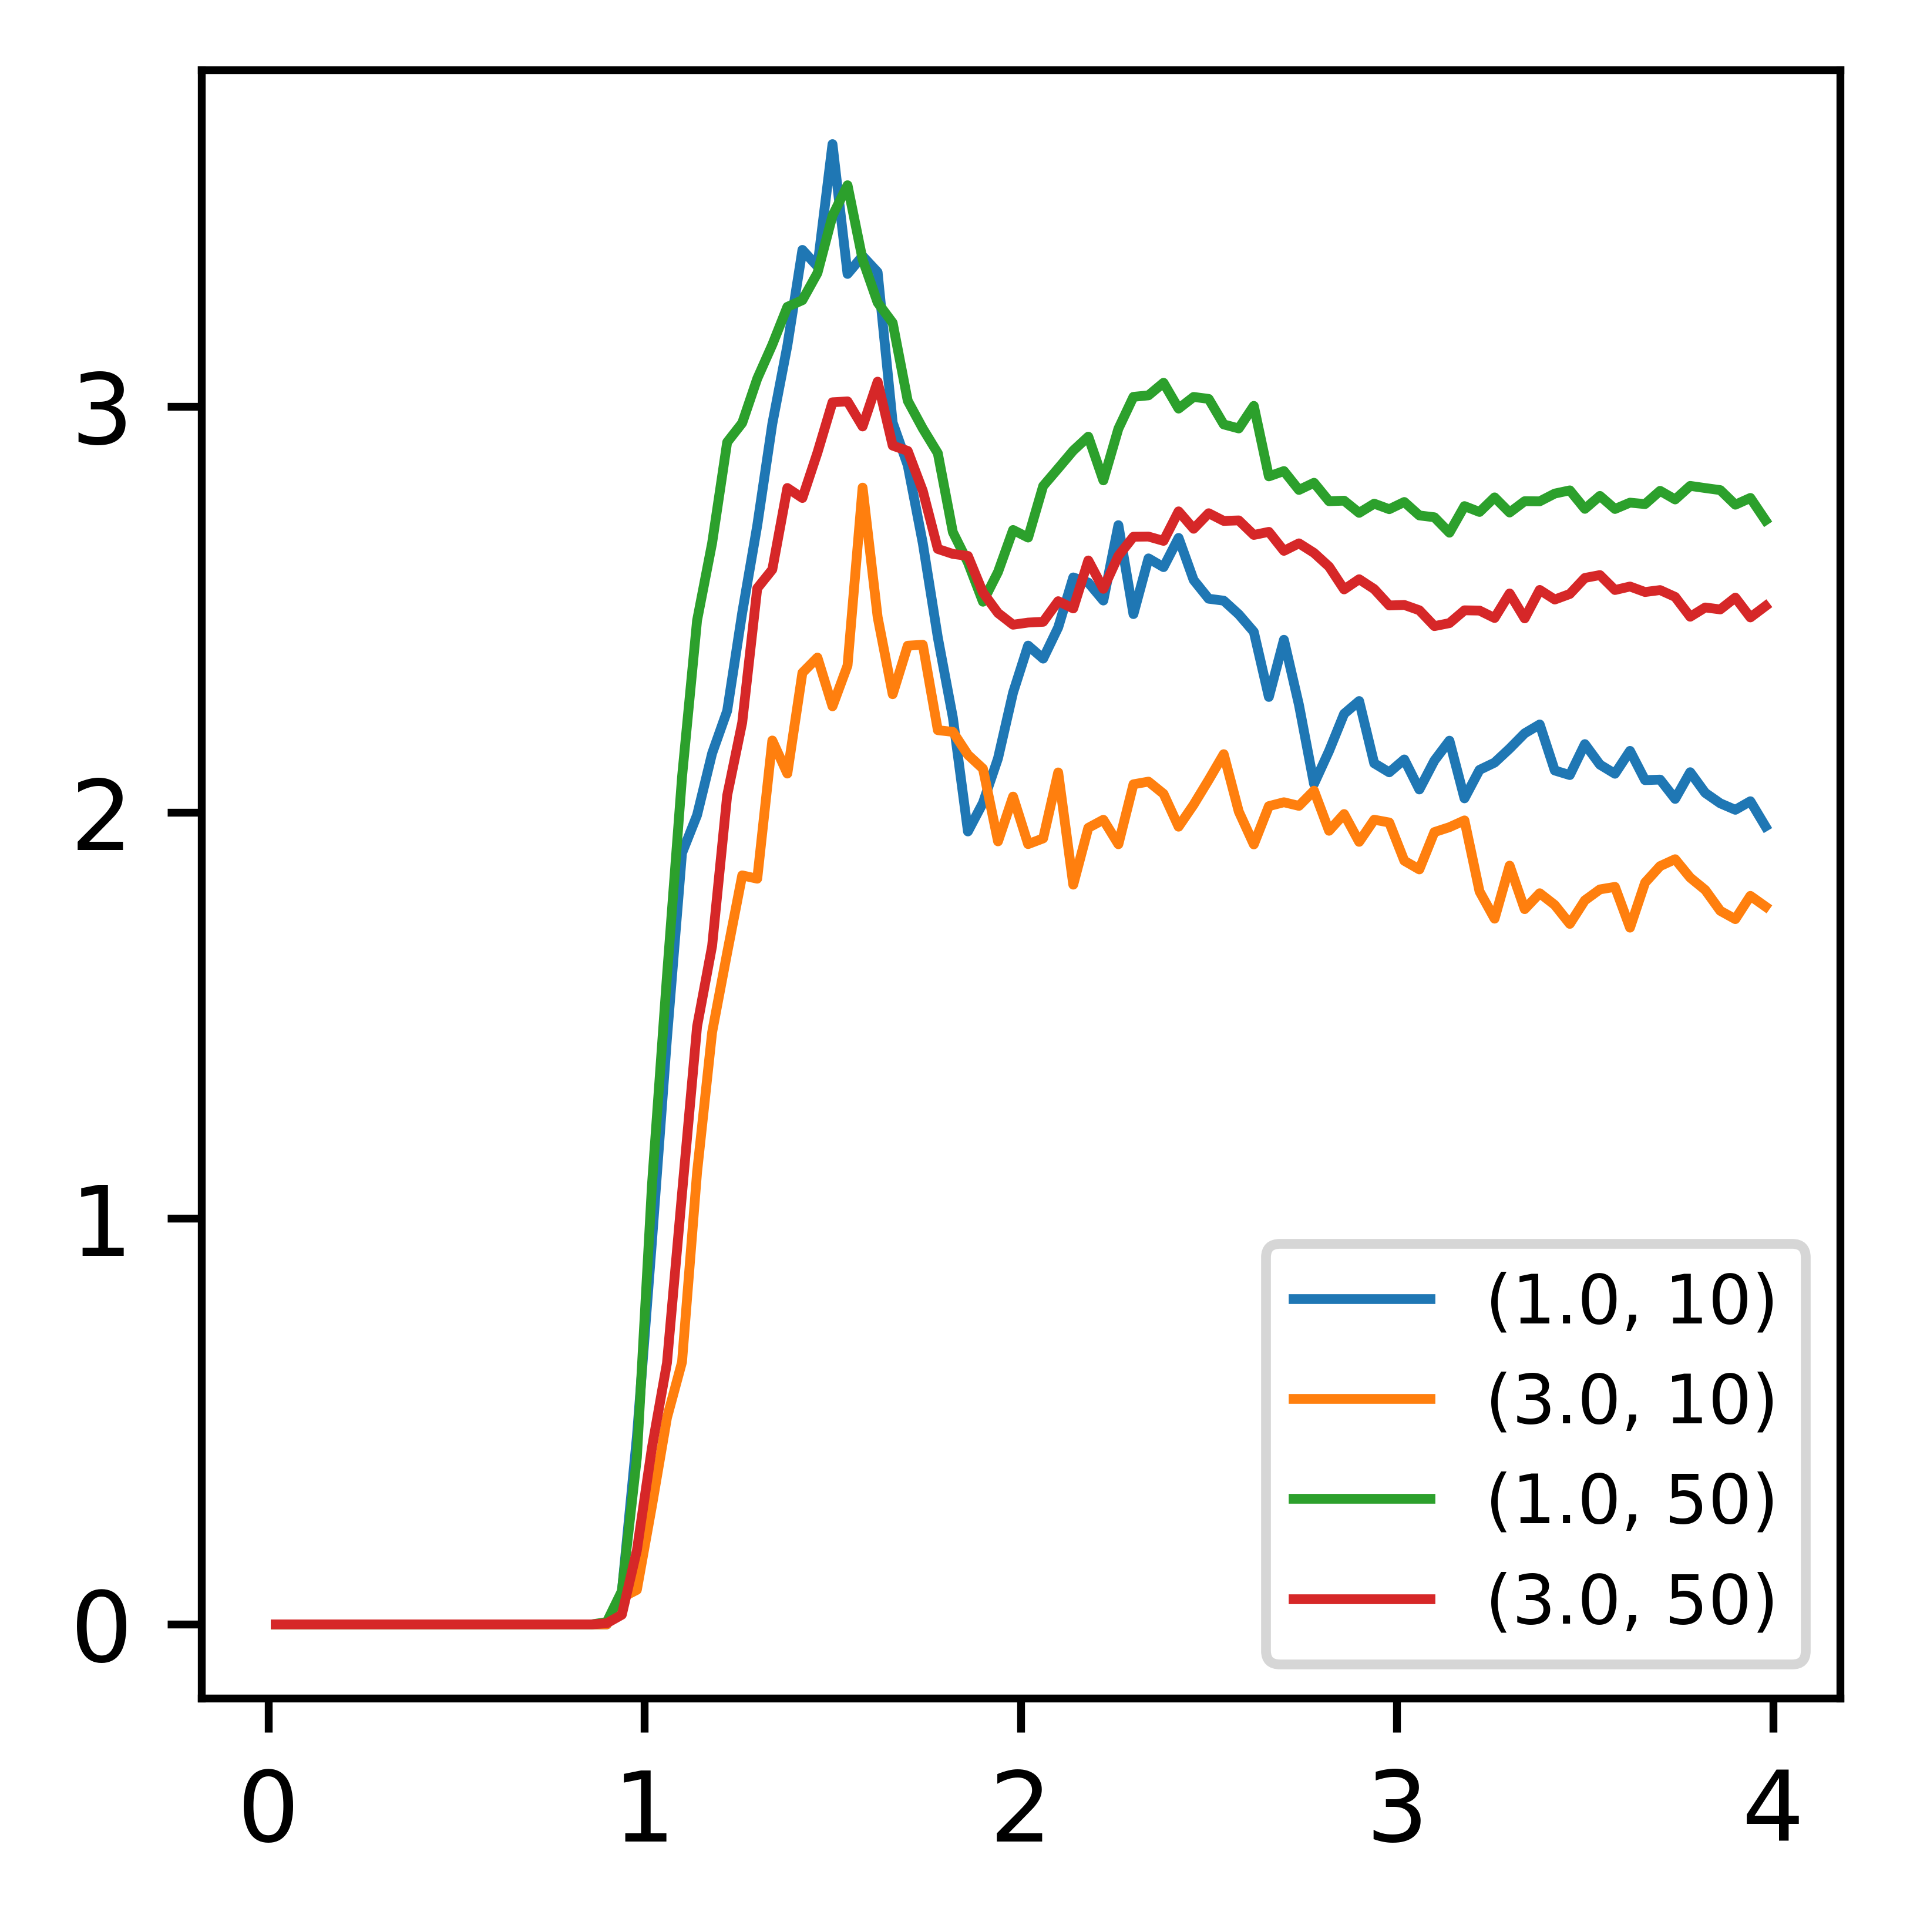

In [6]:
for job in project:
    print(job.id, job.sp.kT, job.sp.num_mols)
    rdf, N = gsd_rdf(
        job.fn("target_1monomer_per_bead.gsd"),
        A_name="A",
        B_name="A",
        exclude_bonded=True,
        start=-20,
        stop=-1,
        r_max=4.0
    )
    plt.plot(rdf.bin_centers, rdf.rdf, label=(job.sp.kT, job.sp.num_mols))

plt.legend()

In [10]:
job.sp

{'num_mols': 50, 'lengths': 25, 'density': 0.3, 'remove_hydrogens': True, 'remove_charges': False, 'sigma_scale': 0.96, 'kT': 3.0, 'n_steps': 50000000.0, 'shrink_kT': 4.0, 'shrink_n_steps': 50000000.0, 'shrink_period': 10000, 'r_cut': 2.5, 'tau_kT': 100, 'gsd_write_freq': 100000.0, 'log_write_freq': 10000.0, 'sim_seed': 42}